# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity? This analysis covers the:
1. label frequency
2. text frequency
3. confidence score distribution
4. text length
5. text complexity

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?    (`label`)
2. Are low-confidence predictions associated with text frequency/rarity?    (`text`)
3. Do certain label types show systematic confidence patterns?              (`label`)
4. Is confidence score correlated with text length?                         (`text`)
5. Is confidence score correlated with complexity?                          (`text`)

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes.
* If low scores correlate with rare words: Add domain-specific vocabulary for training.
* If low scores are consistent with certain label group: Focused annotation to cator specific labelings.

If all are unclear: Review model architecture or hyperparameter tuning

-------------
------
## Data Pre-processing

#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

#### Load Dataset

In [ ]:
# load csv
df = pd.read_csv('results_main.csv')
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
df.info

<bound method DataFrame.info of          start      end                text     label     score
0           32       37               gempa     EVENT  0.894353
1           40       55     utusan malaysia       ORG  0.768264
2           63       66                 umt       ORG  0.891914
3           75       93  majlis konvokesyen     EVENT  0.919138
4           96      111     utusan malaysia       ORG  0.785904
...        ...      ...                 ...       ...       ...
23989  1462061  1462075      berpuluh-puluh  QUANTITY  0.605398
23990  1462089  1462094               gempa     EVENT  0.639610
23991  1462119  1462125              bandar       LOC  0.572937
23992  1462135  1462143            istanbul       LOC  0.941040
23993  1462175  1462180               izmir       LOC  0.973139

[23994 rows x 5 columns]>

In [ ]:
# normalize text
df['text'] = df['text'].str.lower()
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# duplicates
df.drop_duplicates().head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


-------------
--------
## Exploratory Data Analysis
This part aims to explore the dataset in hopes to uncover hidden perspectives.

#### Label Distribution

In [ ]:
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# label distribution
df['label'].value_counts()

label
ORG            5848
PERSON         5367
LOC            5144
EVENT          1675
GPE            1277
PRODUCT        1213
TIME           1080
MONEY           707
QUANTITY        508
LAW             444
WORK_OF_ART     246
PERCENT         205
CARDINAL        139
NORP             77
FAC              62
ORDINAL           2
Name: count, dtype: int64

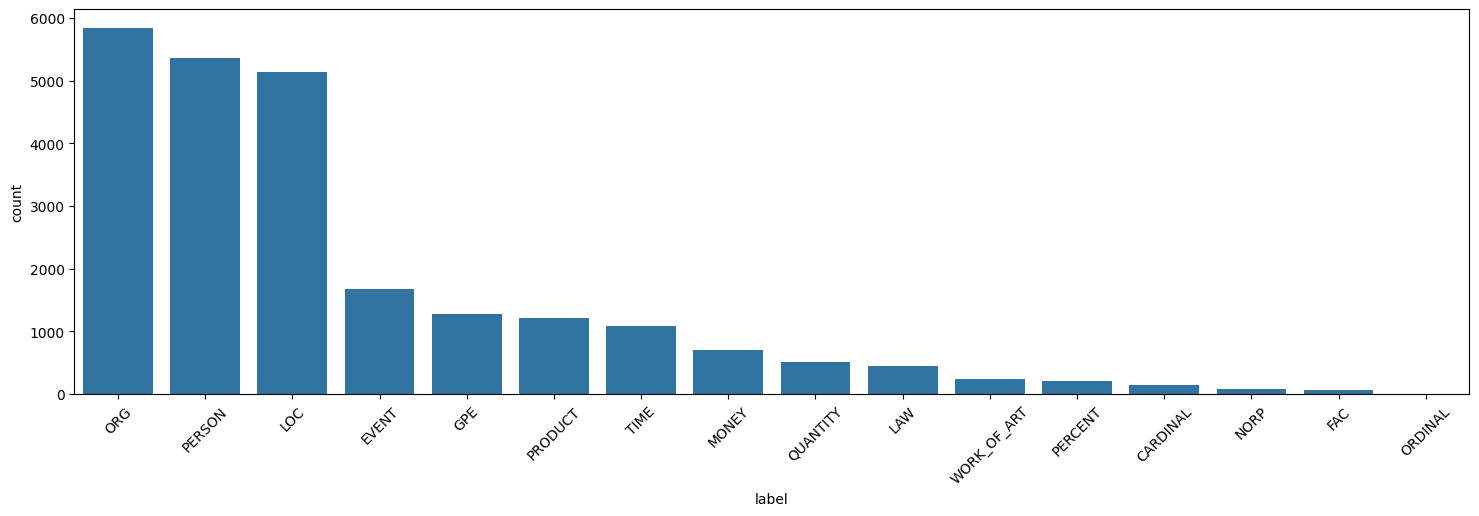

In [ ]:
# visualize
label_freq = df['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=df['label'],data=df, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe to assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels. This is because the gap between the third and the fourth highest is relatively big (1500 vs 500), when compared to other inter-label gaps.

#### High and Low Frequency Labels

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# drop columns
freq = df.drop(['start','end','text'], axis=1)
freq.head()

,label,score
0,EVENT,0.894353
1,ORG,0.768264
2,ORG,0.891914
3,EVENT,0.919138
4,ORG,0.785904


In [ ]:
# list labels
freq['label'].unique()

array(['EVENT', 'ORG', 'PERSON', 'QUANTITY', 'GPE', 'PRODUCT', 'MONEY',
       'LOC', 'LAW', 'TIME', 'PERCENT', 'WORK_OF_ART', 'CARDINAL', 'NORP',
       'FAC', 'ORDINAL'], dtype=object)

In [ ]:
# split into higher and lower frequency groups
high_freq_label = ['PERSON','ORG','LOC']
low_freq_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

freq_high = freq[freq['label'].isin(high_freq_label)]
freq_low = freq[freq['label'].isin(low_freq_label)]

#### Confidence Score Disctribution

In [ ]:
# get mean confidence score
conf = df.groupby('label')['score'].mean().reset_index()
conf = conf.sort_values('score', ascending=False)

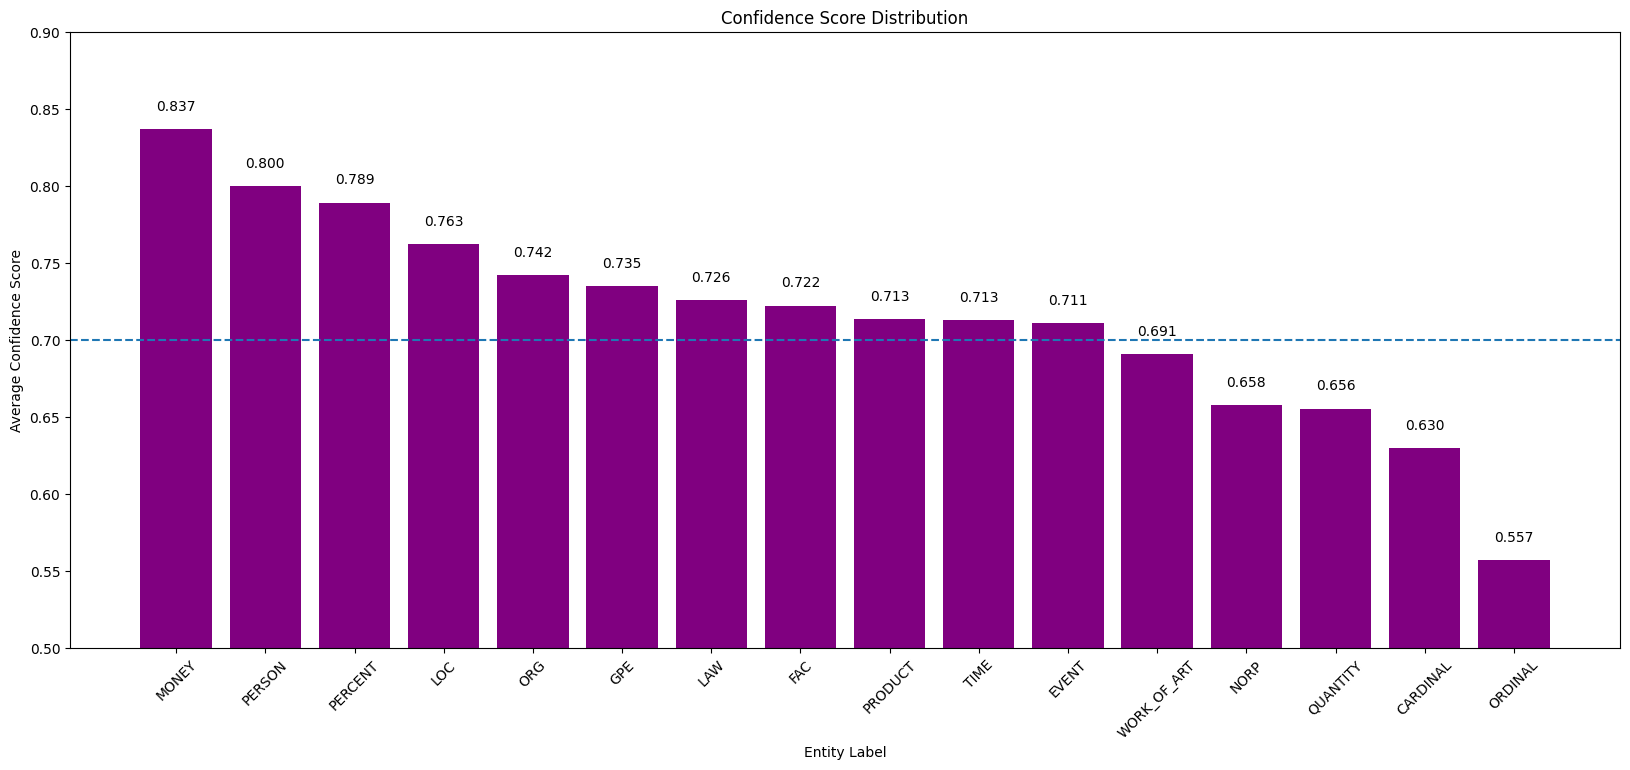

In [ ]:
# visualize
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1) 
bars = ax.bar(conf['label'], conf['score'], color='purple')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + 0.01, f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

ax.set_title('Confidence Score Distribution')
ax.set_xlabel('Entity Label')
ax.set_ylabel('Average Confidence Score')
ax.set_ylim(0.5, 0.9)
ax.axhline(y=0.7,linestyle='--')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()


Based on this distribution, there are 5 labels that are considered to be low-confidence.

#### Confidence Scores in High and Low Frequency Labels

In [ ]:
# get mean score
label_score_mean_high = freq_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = freq_low.groupby('label')['score'].mean().reset_index()

In [ ]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

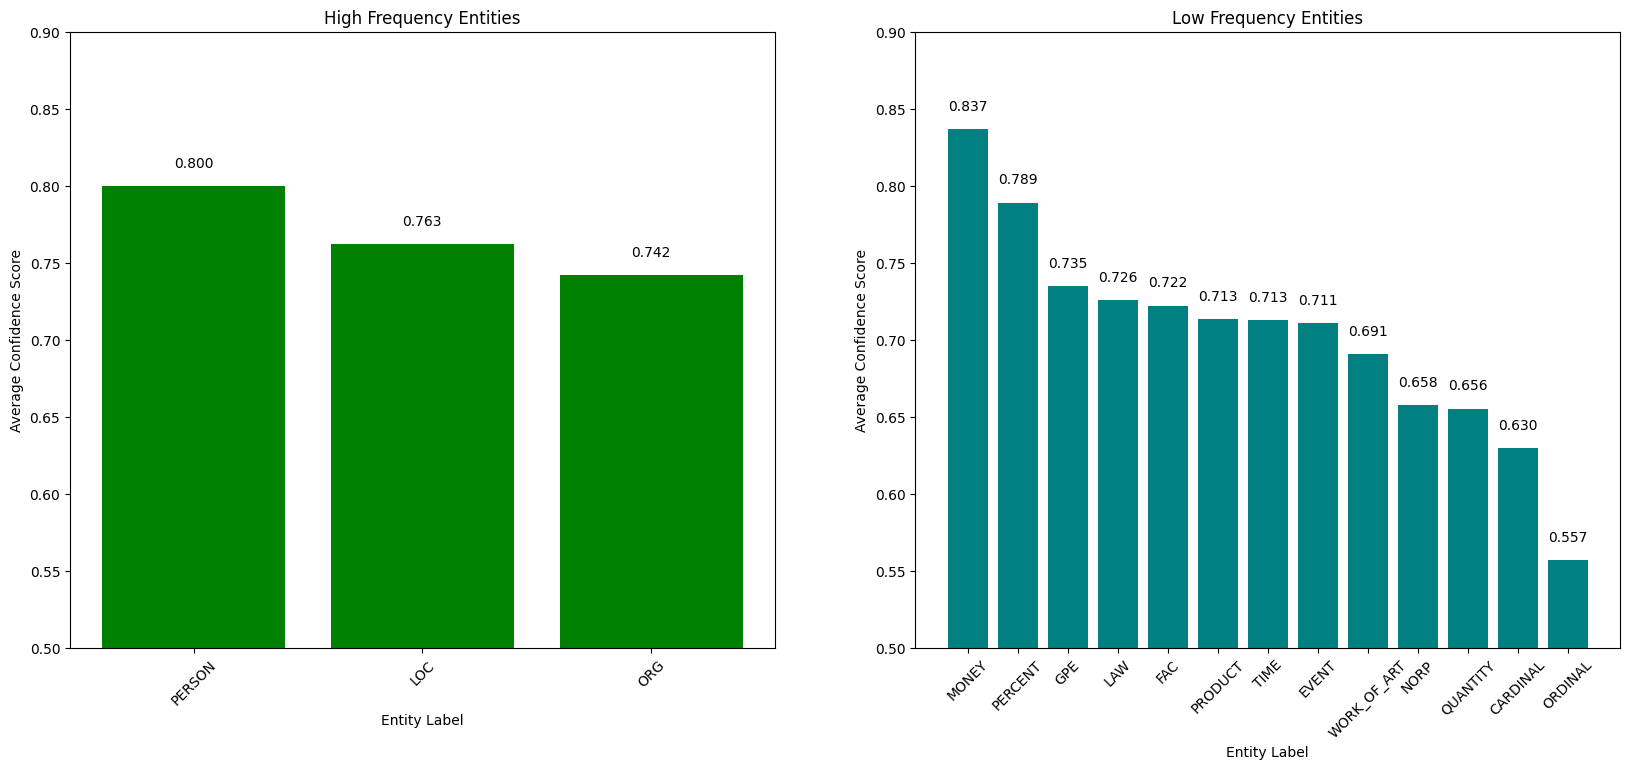

In [ ]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

#### Low Rarity Texts

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# text frequency
text_freq = df['text'].value_counts().reset_index() 
text_freq

,text,count
0,utusan malaysia,624
1,kuala lumpur,374
2,malaysia,372
3,polis,188
4,petaling jaya,136
...,...,...
9439,jejaki,1
9440,26 saat,1
9441,akta kanak-kanak 2001,1
9442,seksyen 31(1),1


In [ ]:
# texts that appeared only once
text_low = text_freq[text_freq['count'] == 1]
text_low

,text,count
3174,landasan,1
3175,penjawat awam kanan,1
3176,pasir gudang,1
3177,watsons international,1
3178,caryn loh,1
...,...,...
9439,jejaki,1
9440,26 saat,1
9441,akta kanak-kanak 2001,1
9442,seksyen 31(1),1


From this, there are about 4000 texts that appeared only once. That's more than half of the whole dataset (6000 texts)! This is also while excluding the texts that appeared only twice or thrice.

However, this is to be expected since texts with unique nomenclature or numbers might be a factor to this phenomenon. 

#### Distribution of Confidence Score in Low Rarity Texts

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# get score for low rarity texts
text_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_low_conf = pd.merge(text_freq, text_conf, on='text')
text_low_conf = text_low_conf[text_low_conf['count'] == 1]
text_low_conf.sort_values('score',ascending=False)

,text,count,score
5365,harvey elliott,1,0.995564
5310,novak djokovic,1,0.995105
5352,harry maguire,1,0.994720
5233,mimi fly,1,0.994010
5356,muhammad yunus,1,0.993510
...,...,...,...
3779,kejohanan sukan sea,1,0.500327
4046,calon mentua,1,0.500295
3772,kampung glam,1,0.500206
4373,bekalan makanan,1,0.500189


Here, we can see that the rare texts has the confidence score at both high and low ends.

In [ ]:
score_low = df[df['score'] < 0.7]
score_low.sort_values('score',ascending=False)

,start,end,text,label,score
11445,643099,643106,kemboja,GPE,0.699989
8680,388251,388263,pelitup muka,PRODUCT,0.699989
3810,73376,73379,ceo,PERSON,0.699948
7147,263649,263658,pertemuan,EVENT,0.699943
1690,33761,33776,utusan malaysia,ORG,0.699939
...,...,...,...,...,...
20062,1319810,1319816,gambar,WORK_OF_ART,0.500136
2690,53185,53190,kubur,ORG,0.500109
18633,1243613,1243620,majikan,ORG,0.500095
9636,472592,472596,ajaz,PERSON,0.500067


There are about 5000 texts that has low confidence scores.

#### Distribution of Text Lengths

In [ ]:
txt_len = df.copy()
txt_len['chara'] = df['text'].str.len()
txt_len

,start,end,text,label,score,chara
0,32,37,gempa,EVENT,0.894353,5
1,40,55,utusan malaysia,ORG,0.768264,15
2,63,66,umt,ORG,0.891914,3
3,75,93,majlis konvokesyen,EVENT,0.919138,18
4,96,111,utusan malaysia,ORG,0.785904,15
...,...,...,...,...,...,...
23989,1462061,1462075,berpuluh-puluh,QUANTITY,0.605398,14
23990,1462089,1462094,gempa,EVENT,0.639610,5
23991,1462119,1462125,bandar,LOC,0.572937,6
23992,1462135,1462143,istanbul,LOC,0.941040,8


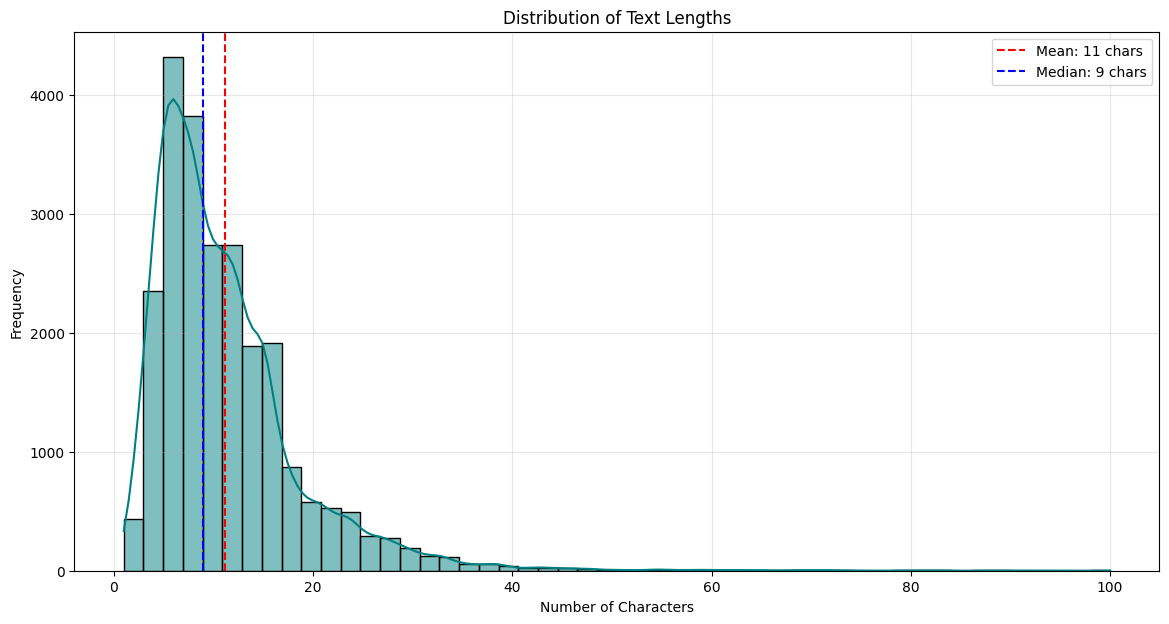

In [ ]:
# distribution of text length
plt.figure(figsize=(14, 7))

# histogram
sns.histplot(txt_len['chara'], bins=50, kde=True, color='teal')

# mean line
mean_length = txt_len['chara'].mean()
plt.axvline(mean_length, color='red', linestyle='--', 
            label=f'Mean: {mean_length:.0f} chars')

# median line
median_length = txt_len['chara'].median()
plt.axvline(median_length, color='blue', linestyle='--', 
            label=f'Median: {median_length:.0f} chars')

# plot
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

This distribution histogram is right-skewed. It comprises of mostly short texts.

--------------
--------------
## Data Analysis

-------------
### Q1: Is there a correlation between label frequency and confidence scores?
Study on the mean confidence scores and label frequency correlation. This is to see if high frequency means high confidence score, or vice versa.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# create new dataset
q1_label = df['label'].value_counts().reset_index()         # get label frequency
q1_conf = df.groupby('label')['score'].mean().reset_index() # get mean confidence score

q1_label_analysis = pd.merge(q1_label, q1_conf, on='label')
q1_label_analysis.sort_values('score',ascending=False)

,label,count,score
7,MONEY,707,0.837022
1,PERSON,5367,0.800008
11,PERCENT,205,0.789255
2,LOC,5144,0.762612
0,ORG,5848,0.742178
4,GPE,1277,0.735275
9,LAW,444,0.725918
14,FAC,62,0.722408
5,PRODUCT,1213,0.713445
6,TIME,1080,0.712895


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship
3. Shapiro-Wilk test - to determine if its normally distributed

**Null hypothesis:**\
There is no correlation between label frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between label frequency and confidence scores.

In [ ]:
# pearson
q1_pearson_corr, q1_p_value = stats.pearsonr(
    q1_label_analysis['count'],
    q1_label_analysis['score']
)

# spearman
q1_spearman_rho, q1_p_spearman = stats.spearmanr(
    q1_label_analysis['count'],
    q1_label_analysis['score']
)

# normality test
q1_shapiro_test = stats.shapiro(q1_label_analysis['score'])

In [ ]:
print(f"Spearman rho    : {q1_spearman_rho:.3f}")
print(f"Spearman p      : {q1_p_spearman:.4f}\n")
print(f"Pearson r       : {q1_pearson_corr:.3f}")
print(f"Pearson p       : {q1_p_value:.4f}\n")
print(f"Shapiro-Wilk W  : {q1_shapiro_test[0]:.3f}")
print(f"Shapiro-Wilk p  : {q1_shapiro_test[1]:.4f}\n")

Spearman rho    : 0.553
Spearman p      : 0.0263

Pearson r       : 0.442
Pearson p       : 0.0862

Shapiro-Wilk W  : 0.972
Shapiro-Wilk p  : 0.8671



Based on these results:
* There is a significant (p < 0.05) strong positive monotonic relationship (rho > 0.6). This means that as label frequency increases, confidence scores consistently increase, but not necessarily in a straight-line pattern - Spearman correlation test
* There is a significant (p < 0.05) moderate positive linear relationship (r > 0.4, r < 0.6). This means that higher frequency moderately predicts higher confidence in a linear pattern. - Pearson correlation test
* Since the rho > r, the monotonic relationship is stronger than the linear relationship. This means that even though higher frequency boosts the confidence score, the boost will decrease with higher frequency.
* Since both of these tests are significant, the results are not random.
* The data is normally distributed (p > 0.05). - Shapiro-Wilk test

Therefore, we reject the null hypothesis.

For fine-tuning, training data that focuses on the low-frequency labels can be used for augmentation.

In [ ]:
# filter low-frequency labels in main dataset
ft_q1 = df[df['label'].isin(low_freq_label)]
ft_q1 = ft_q1[ft_q1['score'] < 0.7]
ft_q1.sort_values('score')

,start,end,text,label,score
20062,1319810,1319816,gambar,WORK_OF_ART,0.500136
1605,32003,32018,bekalan makanan,PRODUCT,0.500189
4805,89668,89672,maut,EVENT,0.500217
4769,89178,89182,maut,EVENT,0.500217
16539,1069893,1069912,kejohanan sukan sea,EVENT,0.500327
...,...,...,...,...,...
18115,1199191,1199201,rm210 juta,MONEY,0.699715
8245,359345,359365,separuh masa pertama,TIME,0.699883
7147,263649,263658,pertemuan,EVENT,0.699943
8680,388251,388263,pelitup muka,PRODUCT,0.699989


------------
### Q2: Are low-confidence predictions correlated with text frequency/rarity?
Study on the low confidence scores and text frequency. This is to see if lower rarity means lower confidence score, or vice versa.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# create new dataset
q2_text = df['text'].value_counts().reset_index()           # get text frequency
q2_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

q2_text_analysis = pd.merge(q2_text, q2_conf, on='text')
q2_text_analysis

,text,count,score
0,utusan malaysia,624,0.712863
1,kuala lumpur,374,0.863369
2,malaysia,372,0.731764
3,polis,188,0.776786
4,petaling jaya,136,0.751873
...,...,...,...
9439,jejaki,1,0.721619
9440,26 saat,1,0.629982
9441,akta kanak-kanak 2001,1,0.920611
9442,seksyen 31(1),1,0.503450


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text frequency and confidence scores.

In [ ]:
# pearson
q2_pearson_corr, q2_p_value = stats.pearsonr(
    q2_text_analysis['count'],
    q2_text_analysis['score']
)

# spearman
q2_spearman_rho, q2_p_spearman = stats.spearmanr(
    q2_text_analysis['count'],
    q2_text_analysis['score']
)

In [ ]:
print(f"Spearman rho: {q2_spearman_rho:.3f}")
print(f"Spearman p: {q2_p_spearman:.4f}\n")
print(f"Pearson r: {q2_pearson_corr:.3f}")
print(f"Pearson p: {q2_p_value:.4f}\n")

Spearman rho: 0.029
Spearman p: 0.0050

Pearson r: 0.007
Pearson p: 0.5052



Based on these results:
* There is a significant (p < 0.05) but negligible monotonic relationship (rho < 0.1). This means that there is no meaningful relationship between text and confidence score. - Spearman correlation test
* There is no significant (p > 0.05) linear relationship (r < 0.1). This means that there is no evidence of linear relationship between text and confidence score. - Pearson correlation test

Therefore, we do not reject the null hypothesis.

The fine-tuning should be aimed at other factors instead.

This further justifies the EDA,  where the confidence scores are covered from both high and low ends from the texts, despite the rarity of the texts.

------------
### Q3: Do certain label types show systematic confidence patterns?
Analyze low confidence score distributions per label type. This is to see whether certain labels are under-trained.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# sort and filter score < 0.7
q3 = df.sort_values('score', ascending=False)
q3 = q3[q3['score'] < 0.7]
q3

,start,end,text,label,score
11445,643099,643106,kemboja,GPE,0.699989
8680,388251,388263,pelitup muka,PRODUCT,0.699989
3810,73376,73379,ceo,PERSON,0.699948
7147,263649,263658,pertemuan,EVENT,0.699943
1690,33761,33776,utusan malaysia,ORG,0.699939
...,...,...,...,...,...
20062,1319810,1319816,gambar,WORK_OF_ART,0.500136
2690,53185,53190,kubur,ORG,0.500109
18633,1243613,1243620,majikan,ORG,0.500095
9636,472592,472596,ajaz,PERSON,0.500067


In [ ]:
# number of labels
print(f"number of labels with low-scores    : {len(q3['label'].unique())}")
print(f"number of labels on main            : {len(df['label'].unique())}")

number of labels with low-scores    : 16
number of labels on main            : 16


It seems that there are low-confidence scores for all  types of lables. However, based on our EDA, the lables that has low-average confidence scores are the FAC, NORP, QUANTITY, CARDINAL, and ORDINAL (5 labels). This might be because of outliers in each label type. But to be sure, the weight of the low confidence scores and high confidence scores can be measured for each label. Since the number of the scores cannot be compared because of relative frequencies, percentages can be used for the comparison. 

#### Compare Confidence Score of Individual Labels
Get horizontal bar chart for each label (16 bar charts), with confidence score of 0.7 as the sperator for each chart.

In [ ]:
# get back full dataset
q3 = df
q3.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# get number labels of high and low confidence
q3_conf = q3.groupby('label')['score'].agg(
    high_conf=lambda x: (x >= 0.7).sum(),
    low_conf=lambda x: (x < 0.7).sum(),
    total='count'
).reset_index()
q3_conf

,label,high_conf,low_conf,total
0,CARDINAL,28,111,139
1,EVENT,842,833,1675
2,FAC,35,27,62
3,GPE,767,510,1277
4,LAW,245,199,444
5,LOC,3455,1689,5144
6,MONEY,590,117,707
7,NORP,27,50,77
8,ORDINAL,0,2,2
9,ORG,3560,2288,5848


In [ ]:
# get percentages
q3_conf['high_conf_pct'] = (q3_conf['high_conf'] / q3_conf['total'] * 100).round(1)
q3_conf['low_conf_pct'] = (q3_conf['low_conf'] / q3_conf['total'] * 100).round(1)
q3_conf

,label,high_conf,low_conf,total,high_conf_pct,low_conf_pct
0,CARDINAL,28,111,139,20.1,79.9
1,EVENT,842,833,1675,50.3,49.7
2,FAC,35,27,62,56.5,43.5
3,GPE,767,510,1277,60.1,39.9
4,LAW,245,199,444,55.2,44.8
5,LOC,3455,1689,5144,67.2,32.8
6,MONEY,590,117,707,83.5,16.5
7,NORP,27,50,77,35.1,64.9
8,ORDINAL,0,2,2,0.0,100.0
9,ORG,3560,2288,5848,60.9,39.1


In [ ]:
# Sort by high confidence percentage (descending)
q3_conf = q3_conf.sort_values('high_conf_pct', ascending=False)
q3_conf

,label,high_conf,low_conf,total,high_conf_pct,low_conf_pct
6,MONEY,590,117,707,83.5,16.5
10,PERCENT,164,41,205,80.0,20.0
11,PERSON,3940,1427,5367,73.4,26.6
5,LOC,3455,1689,5144,67.2,32.8
9,ORG,3560,2288,5848,60.9,39.1
3,GPE,767,510,1277,60.1,39.9
2,FAC,35,27,62,56.5,43.5
4,LAW,245,199,444,55.2,44.8
14,TIME,571,509,1080,52.9,47.1
12,PRODUCT,640,573,1213,52.8,47.2


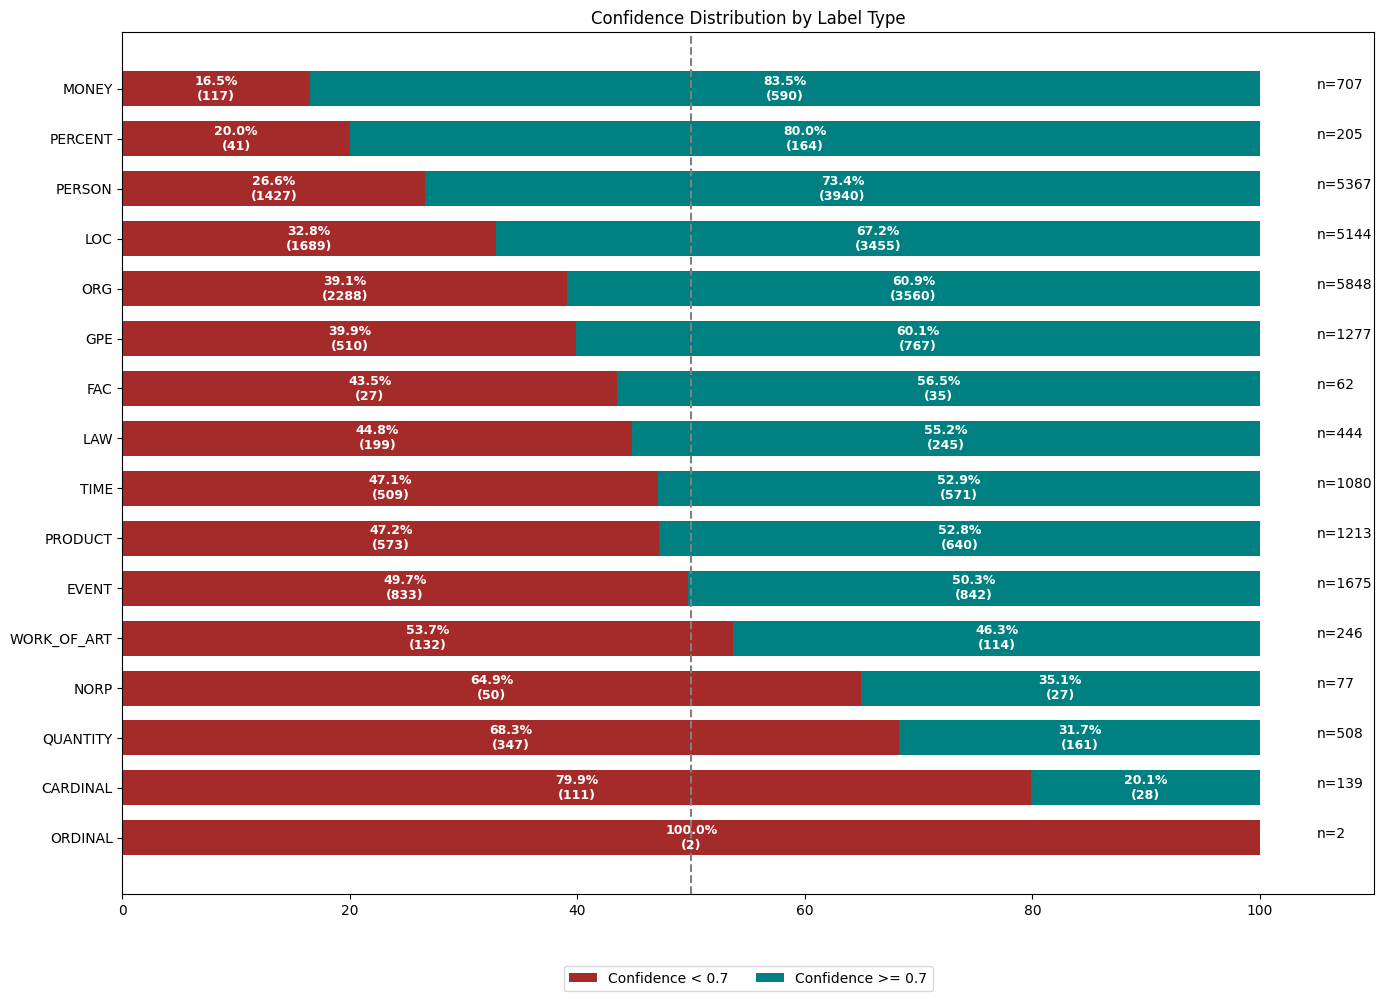

In [ ]:
# visualize
plt.figure(figsize=(14, 10))
y_pos = np.arange(len(q3_conf))
bar_height = 0.7

# stacked horizontal bar charts
low_bars = plt.barh(y_pos, q3_conf['low_conf_pct'], 
                    height=bar_height, color='brown', label='Confidence < 0.7')
high_bars = plt.barh(y_pos, q3_conf['high_conf_pct'], 
                     left=q3_conf['low_conf_pct'], 
                     height=bar_height, color='teal', label='Confidence >= 0.7')

# annotations
for i, (low_pct, high_pct, total) in enumerate(zip(q3_conf['low_conf_pct'], 
                                                   q3_conf['high_conf_pct'], 
                                                   q3_conf['total'])):
    # low confidence scores
    if low_pct > 1:     # to ensure space
        plt.text(low_pct/2, i, 
                 f'{low_pct:.1f}%\n({int(q3_conf["low_conf"].iloc[i])})', 
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # high confidence scores
    if high_pct > 1:    # to ensure space 
        plt.text(q3_conf['low_conf_pct'].iloc[i] + high_pct/2, i, 
                 f'{high_pct:.1f}%\n({int(q3_conf["high_conf"].iloc[i])})', 
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # total
    plt.text(105, i, f'n={total}')

    # line at 50%

# plot
plt.axvline(x=50, color='grey', linestyle='--')
plt.gca().invert_yaxis()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.yticks(y_pos, q3_conf['label'])
plt.title('Confidence Distribution by Label Type')
plt.xlim(0, 110)
plt.tight_layout()
plt.show()

There are a few key points that can be taken away from this chart, but to break it down further:

Based on >= 50% high confidence score coverage(10 labels):
* Even though 'MONEY','PERCENT', 'GPE', 'LAW', 'TIME', 'PRODUCT', and 'EVENT' are considered to be low-frequency labels, based on the EDA, they have high confidence score coverage.
* The high-frequency labels, 'ORG', 'PERSON', and 'LOC' all have high confidence score coverage.
* The 'PERCENT' may be an outlier, because despite having the lowest number of labels in this category, it is has the second highest high confidence score coverage. This might be because of the simplicity/less variability of the annotation i.e. the symbol '%' is used as the indication for the label.

Based on < 50% high confidence score coverage(6 labels):
* All of the labels in these category are the low-frequency labels based on the EDA.
* The ' QUANTITY' label may in an outlier, because despite having the highest number of labels, about double from the second highest, it is has a poor high confidence score coverage. This might be because of the variability of the annotation, from being numbers.

From this, a label-focused annotation can be done for the fine-tuning:
* 'ORDINAL', 'CARDINAL', 'QUANTITY', 'NORP', 'WORK_OF_ART', and 'EVENT' should be the labels of focus.

In [ ]:
# get low high confidence covergage labels with low confidence
low_high_cov_label = ['ORDINAL', 'CARDINAL', 'QUANTITY', 'NORP', 'WORK_OF_ART', 'EVENT']

ft_q3 = df[df['label'].isin(low_high_cov_label)]
ft_q3 = ft_q3[ft_q3['score'] < 0.7]
ft_q3.sort_values('score')

,start,end,text,label,score
20062,1319810,1319816,gambar,WORK_OF_ART,0.500136
4769,89178,89182,maut,EVENT,0.500217
4805,89668,89672,maut,EVENT,0.500217
16539,1069893,1069912,kejohanan sukan sea,EVENT,0.500327
12489,728458,728497,majlis memetrai memorandum persefahaman,EVENT,0.500333
...,...,...,...,...,...
15744,996810,996834,sukan olimpik paris 2024,EVENT,0.699123
9094,422487,422502,kebakaran hutan,EVENT,0.699162
13398,798168,798182,modus operandi,WORK_OF_ART,0.699344
8292,362276,362342,"haji.\r\n\r\ndalam pada itu, jurucakap komande...",EVENT,0.699439


-----------
### Q4: Is confidence score correlated with text length or complexity?
Find the correlation between length of texts and confidence scores.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# get characters
q4_chara_analysis = txt_len.copy()
q4_chara_analysis

,start,end,text,label,score,chara
0,32,37,gempa,EVENT,0.894353,5
1,40,55,utusan malaysia,ORG,0.768264,15
2,63,66,umt,ORG,0.891914,3
3,75,93,majlis konvokesyen,EVENT,0.919138,18
4,96,111,utusan malaysia,ORG,0.785904,15
...,...,...,...,...,...,...
23989,1462061,1462075,berpuluh-puluh,QUANTITY,0.605398,14
23990,1462089,1462094,gempa,EVENT,0.639610,5
23991,1462119,1462125,bandar,LOC,0.572937,6
23992,1462135,1462143,istanbul,LOC,0.941040,8


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text length and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text length and confidence scores.

In [ ]:
# pearson
q4_pearson_corr, q4_p_value = stats.pearsonr(
    q4_chara_analysis['chara'],
    q4_chara_analysis['score']
)

# spearman
q4_spearman_rho, q4_p_spearman = stats.spearmanr(
    q4_chara_analysis['chara'],
    q4_chara_analysis['score']
)

In [ ]:
# display
print(f"Spearman rho: {q4_spearman_rho:.3f}")
print(f"Spearman p: {q4_p_spearman:.4f}\n")
print(f"Pearson r: {q4_pearson_corr:.3f}")
print(f"Pearson p: {q4_p_value:.4f}\n")

Spearman rho: 0.103
Spearman p: 0.0000

Pearson r: 0.059
Pearson p: 0.0000



Based on these readings,

There is a highly significant (p < 0.05) weak positive monotonic and linear relationship (rho < 0.4, r < 0.4). This means that the effects of the text length to confidence score is negligible.

Therefore, we reject the null hypothesis. However, the relationship has no practical importance.

So, no fine-tuning can be uased by the text lengths.

-----------
### Q5: Is confidence score correlated with text complexity?
Find the correlation between the complexity of texts and confidence scores.

#### Data Preparation

In [ ]:
# overview
df.head()

,start,end,text,label,score
0,32,37,gempa,EVENT,0.894353
1,40,55,utusan malaysia,ORG,0.768264
2,63,66,umt,ORG,0.891914
3,75,93,majlis konvokesyen,EVENT,0.919138
4,96,111,utusan malaysia,ORG,0.785904


In [ ]:
# feature selection
q5_complex_analysis = df[['text', 'score']].copy()
q5_complex_analysis

,text,score
0,gempa,0.894353
1,utusan malaysia,0.768264
2,umt,0.891914
3,majlis konvokesyen,0.919138
4,utusan malaysia,0.785904
...,...,...
23989,berpuluh-puluh,0.605398
23990,gempa,0.639610
23991,bandar,0.572937
23992,istanbul,0.941040


In [ ]:
# text processing
text = q5_complex_analysis['text']
words = text.str.split()
word_count = words.str.len()
word_count.sort_values()

0         1
13028     1
13031     1
13033     1
13034     1
         ..
14050    12
5617     12
17269    12
11440    12
15717    12
Name: text, Length: 23994, dtype: int64

In [ ]:
# word diversity
word_diversity = words.apply(set).str.len() / word_count
word_diversity.sort_values()

20622    0.666667
13916    0.666667
18341    0.666667
5709     0.666667
7062     0.666667
           ...   
7995     1.000000
7994     1.000000
7993     1.000000
8002     1.000000
23993    1.000000
Name: text, Length: 23994, dtype: float64

In [ ]:
# average word length
avg_word_length = words.str.join(' ').str.len() / word_count
avg_word_length.sort_values()

3286      1.0
890       1.0
18335     1.0
1757      1.0
4772      1.0
         ... 
13       19.0
12903    21.0
12939    21.0
12931    21.0
17061    21.0
Name: text, Length: 23994, dtype: float64

In [ ]:
# special character ratio
special_char_ratio = text.str.count(r'[^\w\s]') / text.str.len()
special_char_ratio.sort_values()

0        0.0
15749    0.0
15748    0.0
15747    0.0
15746    0.0
        ... 
8502     0.5
8506     0.5
1520     0.5
8500     0.5
8498     0.5
Name: text, Length: 23994, dtype: float64

In [ ]:
# average complexity
q5_complex_analysis = q5_complex_analysis.assign(
    complexity=(
        word_diversity + 
        avg_word_length / 10 + 
        special_char_ratio
    ) / 3  
)

In [ ]:
# display
q5_complexity = q5_complex_analysis[['text', 'score', 'complexity']].sort_values('complexity')
q5_complexity.sort_values('complexity')

,text,score,complexity
20555,bae sobar bae,0.763921,0.366667
20154,bea sobar bea,0.686008,0.366667
20622,bae sobar bae,0.763921,0.366667
19010,bea sobar bea,0.704601,0.366667
13898,1,0.579481,0.366667
...,...,...,...
13,malaysia-azerbaijan,0.626944,0.984211
12939,kontraktor-kontraktor,0.637084,1.049206
17061,pengkritik-pengkritik,0.622965,1.049206
12931,kontraktor-kontraktor,0.593937,1.049206


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text complexity and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text complexity and confidence scores.

In [ ]:
# pearson
q5_pearson_corr, q5_p_value = stats.pearsonr(
    q5_complex_analysis['complexity'],
    q5_complex_analysis['score']
)

# spearman
q5_spearman_rho, q5_p_spearman = stats.spearmanr(
    q5_complex_analysis['complexity'],
    q5_complex_analysis['score']
)

In [ ]:
# display
print(f"Spearman rho: {q5_spearman_rho:.3f}")
print(f"Spearman p: {q5_p_spearman:.4f}\n")
print(f"Pearson r: {q5_pearson_corr:.3f}")
print(f"Pearson p: {q5_p_value:.4f}\n")

Spearman rho: 0.005
Spearman p: 0.4013

Pearson r: 0.013
Pearson p: 0.0396



From this: 
* There is a not significant (p > 0.05) positive monotonic relationship (rho < 0.4). - Spearman correlation test
* There is a significant (p < 0.05) positive weak linear relationship (r < 0.4). - Pearson correlation test